Click [here](https://tensor4all.org/T4AJuliaTutorials/_sources/ipynbs/qft.ipynb) to download the notebook locally.


# Quantum Fourier Transform


In [1]:
using PythonCall: PythonCall
using PythonPlot: pyplot as plt, Figure
using LaTeXStrings

# Displays the matplotlib figure object `fig` and avoids duplicate plots.
_display(fig::Figure) = isinteractive() ? (fig; plt.show(); nothing) : Base.display(fig)
_display(fig::PythonCall.Py) = _display(Figure(fig))

import QuanticsGrids as QG
import TensorCrossInterpolation as TCI
using QuanticsTCI: quanticscrossinterpolate, quanticsfouriermpo

## 1D Fourier transform

$$
%\newcommand{\hf}{\hat{f}}   %Fourier transform of \bff
%\newcommand{\hF}{\hat{F}}
$$


Consider a discrete function $f_m \in \mathbb{C}^M$, e.g. the 
discretization, $f_m = f(x(m))$, of a one-dimensional function $f(x)$ on a grid $x(m)$. 
Its discrete Fourier transform (DFT) is

$$
\hat{f}_k = \sum_{m=0}^{M-1}   T_{km} f_m , \qquad 
T_{km} =  \tfrac{1}{\sqrt{M}}  e^{- i 2 \pi k \cdot m /M} .
$$

For a quantics grid, $M = 2^\mathcal{R}$ is exponentially large and the (naive) DFT exponentially expensive to evaluate.
However, the QTT representation of $T$ is known to have a low-rank structure and can be represented as a tensor train with small bond dimensions.

Thus, if the input function $f$ is given in the quantics representation as

<img src="https://raw.githubusercontent.com/tensor4all/T4AJuliaTutorials/main/qft1.png" alt="qft1" width="30%">,

$\hat{f} = T f$ can be computed by efficiently contracting the tensor trains for $T$ and $f$ and recompressing the result:

<img src="https://raw.githubusercontent.com/tensor4all/T4AJuliaTutorials/main/qft2.png" alt="qft contraction" width="60%">.

Note that after the Fourier transform, the quantics indices $\sigma_1,\cdots,\sigma_\mathcal{R}$ are ordered in the inverse order of the input indices $\sigma'_1,\cdots,\sigma'_\mathcal{R}$.
This allows construction of the DFT operator with small bond dimensions.



We consider a function $f(x)$, which is the sum of exponential functions, defined on interval $[0,1]$:

$$
f(x) = \sum_p \frac{c_p}{1 - e^{-\epsilon_p}} e^{-\epsilon_p x}.
$$

Its Fourier transform is given by

$$
\hat{f}_k = \int_0^1 dx \, f(x) e^{i \omega_k x} = - \sum_p \frac{c_p}{i\omega_k - \epsilon_p}.
$$

for $k = 0, 1, \cdots $ and $\omega_k = 2\pi k$.

If you are familiar with quantum field theory, you can think of $f(x)$ as a bosonic correlation function.

In [2]:
coeffs = [1.0, 1.0]
ϵs = [100.0, -50.0]

_exp(x, ϵ) = exp(-ϵ * x)/ (1 - exp(-ϵ))

fx(x) = sum(coeffs .* _exp.(x, ϵs))

fx (generic function with 1 method)

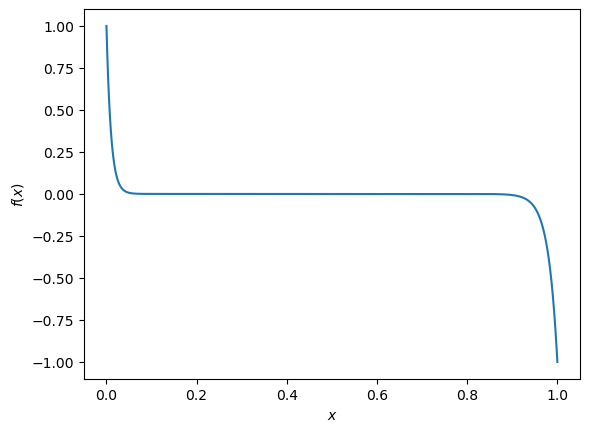

In [3]:
plotx = range(0, 1; length=1000)

fig, ax = plt.subplots()

ax.plot(plotx, fx.(plotx))
ax.set_xlabel(L"x")
ax.set_ylabel(L"f(x)")
_display(fig)

First, we construct a QTT representation of the function $f(x)$.

In [4]:
R = 40
xgrid = QG.DiscretizedGrid{1}(R, 0, 1)

qtci, ranks, errors = quanticscrossinterpolate(Float64, fx, xgrid; tolerance=1e-10)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 2, QuanticsGrids.DiscretizedGrid{1}(40, (0.0,), (1.0,), 2, :fused, false), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 2656 entries), [2, 2, 2], [2.793464338512118e-16, 2.220446049250313e-16, 2.220446049250313e-16])

Second, we compute the Fourier transform of $f(x)$ using the QTT representation of $f(x)$ and the QTT representation of the DFT operator $T$:

$$
\hat{f}_k = \int_0^1 dx \, f(x) e^{i \omega_k x} \approx \frac{1}{M} \sum_{m=0}^{M-1} f_m e^{i 2 \pi k m / M} =  \frac{1}{\sqrt{M}} \sum_{m=0}^{M-1} T_{km} f_m.
$$

for $k = 0, \ldots, M-1$ and $\omega_k = 2\pi k$.
This can be implemented as follows.

In [5]:
# Construct QTT representation of T_{km}
fouriertt = quanticsfouriermpo(R; sign=1.0, normalize=true)

# Apply T_{km} to the QTT representation of f(x)
sitedims = [[2,1] for _ in 1:R]
ftt = TCI.TensorTrain(qtci.tci)
hftt = TCI.contract(fouriertt, ftt; algorithm=:naive, tolerance=1e-8)

hftt *= 1/sqrt(2)^R

@show hftt
;

hftt = TensorCrossInterpolation.TensorTrain{ComplexF64, 3} of rank 18


Let us compare the result with the exact Fourier transform of $f(x)$.

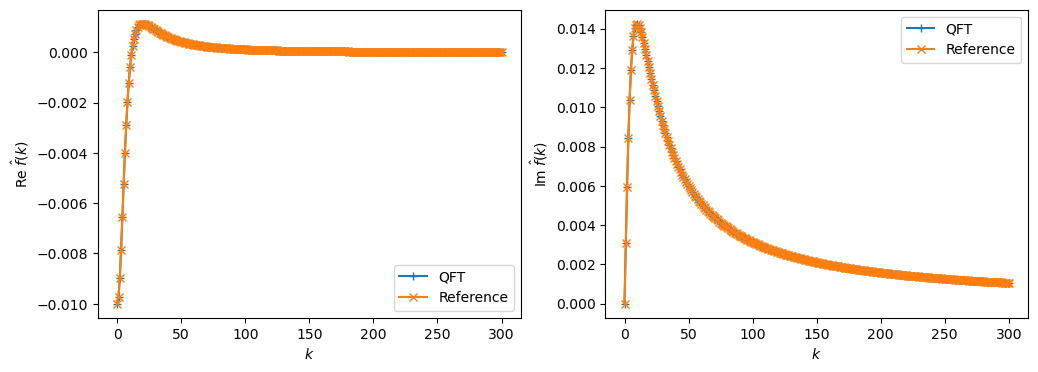

In [6]:
kgrid = QG.InherentDiscreteGrid{1}(R, 0) # 0, 1, ..., 2^R-1

_expk(k, ϵ) = -1 / (2π * k * im - ϵ)
hfk(k) = sum(coeffs .* _expk.(k, ϵs)) # k = 0, 1, 2, ..., 2^R-1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plotk = collect(0:300)
y = [hftt(reverse(QG.origcoord_to_quantics(kgrid, x))) for x in plotk] # Note: revert the order of the quantics indices

ax1.plot(plotk, real.(y), marker="+", label="QFT")
ax1.plot(plotk, real.(hfk.(plotk)), marker="x", label="Reference")
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"\mathrm{Re}~\hat{f}(k)")
ax1.legend()

ax2.plot(plotk, imag.(y), marker="+", label="QFT")
ax2.plot(plotk, imag.(hfk.(plotk)), marker="x", label="Reference")
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"\mathrm{Im}~\hat{f}(k)")
ax2.legend()

_display(fig)

The exponentially large quantics grid allows to compute the Fourier transform with high accuracy at high frequencies.
To check this, let us compare the results at high frequencies.

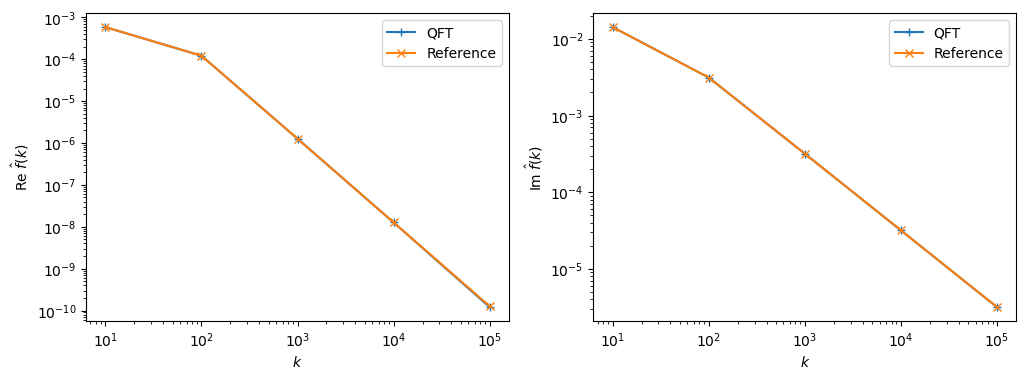

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plotk = [10^n for n in 1:5]
@assert maximum(plotk) <= 2^R-1
y = [hftt(reverse(QG.origcoord_to_quantics(kgrid, x))) for x in plotk] # Note: revert the order of the quantics indices

ax1.loglog(plotk, abs.(real.(y)), marker="+", label="QFT")
ax1.loglog(plotk, abs.(real.(hfk.(plotk))), marker="x", label="Reference")
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"\mathrm{Re}~\hat{f}(k)")
ax1.legend()

ax2.loglog(plotk, abs.(imag.(y)), marker="+", label="QFT")
ax2.loglog(plotk, abs.(imag.(hfk.(plotk))), marker="x", label="Reference")
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"\mathrm{Im}~\hat{f}(k)")
ax2.legend()

_display(fig)

You may use ITensors.jl to compute the Fourier transform of the function $f(x)$.
The following code explains how to do this.

In [8]:
import TCIITensorConversion
using ITensors
import Quantics: fouriertransform, Quantics

sites_m = [Index(2, "Qubit,m=$m") for m in 1:R]
sites_k = [Index(2, "Qubit,k=$k") for k in 1:R]

fmps = MPS(ftt; sites=sites_m)

# Apply T_{km} to the MPS representation of f(x) and reply the result by 1/sqrt(M)
# tag="m" is used to indicate that the MPS is in the "m" basis.
hfmps = (1/sqrt(2)^R) * fouriertransform(fmps; sign=1, tag="m", sitesdst=sites_k)

Precompiling Quantics
  ✓ LinearMaps → LinearMapsStatisticsExt
  1 dependency successfully precompiled in 2 seconds. 109 already precompiled.
[ Info: Precompiling Quantics [87f76fb3-a40a-40c9-a63c-29fcfe7b7547]


Quantics


  ✓ LinearMaps → LinearMapsStatisticsExt
  1 dependency successfully precompiled in 2 seconds. 109 already precompiled.


[ Info: Precompiling Quantics [87f76fb3-a40a-40c9-a63c-29fcfe7b7547]


MPS
[1] ((dim=2|id=778|"l=1,link"), (dim=2|id=347|"Qubit,k=40"))
[2] ((dim=4|id=666|"l=2,link"), (dim=2|id=778|"l=1,link"), (dim=2|id=677|"Qubit,k=39"))
[3] ((dim=7|id=948|"l=3,link"), (dim=4|id=666|"l=2,link"), (dim=2|id=433|"Qubit,k=38"))
[4] ((dim=7|id=468|"l=4,link"), (dim=7|id=948|"l=3,link"), (dim=2|id=518|"Qubit,k=37"))
[5] ((dim=7|id=561|"l=5,link"), (dim=7|id=468|"l=4,link"), (dim=2|id=682|"Qubit,k=36"))
[6] ((dim=8|id=358|"l=6,link"), (dim=7|id=561|"l=5,link"), (dim=2|id=913|"Qubit,k=35"))
[7] ((dim=8|id=52|"l=7,link"), (dim=8|id=358|"l=6,link"), (dim=2|id=573|"Qubit,k=34"))
[8] ((dim=8|id=263|"l=8,link"), (dim=8|id=52|"l=7,link"), (dim=2|id=30|"Qubit,k=33"))
[9] ((dim=8|id=903|"l=9,link"), (dim=8|id=263|"l=8,link"), (dim=2|id=552|"Qubit,k=32"))
[10] ((dim=8|id=313|"l=10,link"), (dim=8|id=903|"l=9,link"), (dim=2|id=295|"Qubit,k=31"))
[11] ((dim=7|id=529|"l=11,link"), (dim=8|id=313|"l=10,link"), (dim=2|id=450|"Qubit,k=30"))
[12] ((dim=7|id=60|"l=12,link"), (dim=7|id=529|"l=11,

In [9]:
# Evaluate Ψ for a given index
_evaluate(Ψ::MPS, sites, index::Vector{Int}) = only(reduce(*, Ψ[n] * onehot(sites[n] => index[n]) for n in 1:length(Ψ)))

_evaluate (generic function with 1 method)

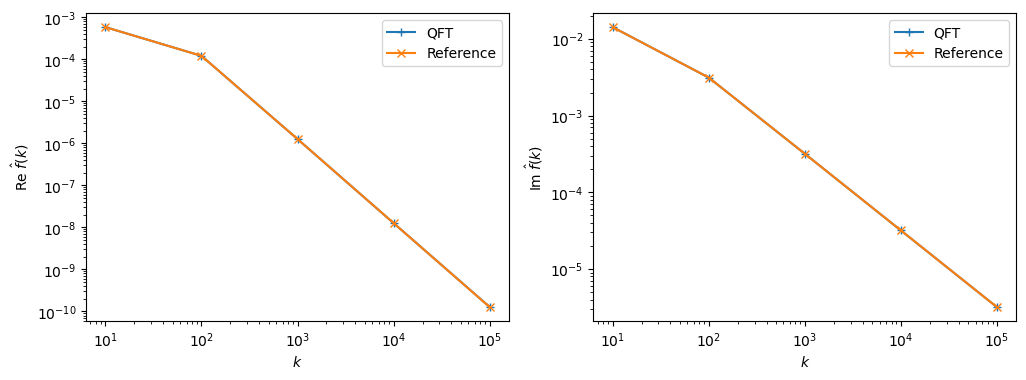

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plotk = [10^n for n in 1:5]
@assert maximum(plotk) <= 2^R-1
y = [_evaluate(hfmps, reverse(sites_k), reverse(QG.origcoord_to_quantics(kgrid, x))) for x in plotk] # Note: revert the order of the quantics indices

ax1.loglog(plotk, abs.(real.(y)), marker="+", label="QFT")
ax1.loglog(plotk, abs.(real.(hfk.(plotk))), marker="x", label="Reference")
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"\mathrm{Re}~\hat{f}(k)")
ax1.legend()

ax2.loglog(plotk, abs.(imag.(y)), marker="+", label="QFT")
ax2.loglog(plotk, abs.(imag.(hfk.(plotk))), marker="x", label="Reference")
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"\mathrm{Im}~\hat{f}(k)")
ax2.legend()

_display(fig)

## 2D Fourier transform

We now consider a two-dimensional function $f(x, y) = \frac{1}{(1 - e^{-\epsilon})(1 - e^{-\epsilon'})} e^{-\epsilon x - \epsilon' y}$ defined on the interval $[0,1]^2$.

Its Fourier transform is given by
$$
\hat{f}_{kl} = \int_0^1  \int_0^1 dx dy \, f(x, y) e^{i \omega_k x + i\omega_l y} \approx \frac{1}{M^2} \sum_{m,n=0}^{M-1} f_{mn} e^{i 2 \pi (k m + l n) / M} =  \frac{1}{M} \sum_{m,n=0}^{M-1} T_{km} T_{ln} f_{mn}.
$$

The exact form of the Fourier transform is
$$
\hat{f}_{kl} = \frac{1}{(i\omega_k - \epsilon) (i\omega_l - \epsilon')}.
$$

for $k, l = 0, 1, \cdots $, $\omega_k = 2\pi k$ and $\omega_l = 2\pi l$.

The 2D Fourier transform can be numerically computed in QTT format (with interleaved representation) in a straightforward way using Quantics.jl.


In [11]:
ϵ = 1.0
ϵprime = 2.0
fxy(x, y) = _exp(x, ϵ) * _exp(y, ϵprime)

# 2D quantics grid using interleaved unfolding scheme
xygrid = QG.DiscretizedGrid{2}(R, (0, 0), (1, 1); unfoldingscheme=:interleaved)

# Resultant QTT representation of f(x, y) has bond dimension of 1.
qtci_xy, ranks_xy, errors_xy = quanticscrossinterpolate(Float64, fxy, xygrid; tolerance=1e-10)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 1, QuanticsGrids.DiscretizedGrid{2}(40, (0.0, 0.0), (1.0, 1.0), 2, :interleaved, false), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 5381 entries), [1, 1, 1], [1.213634401775041e-16, 1.213634401775041e-16, 1.213634401775041e-16])

In [12]:
# for discretizing `y`
sites_n = [Index(2, "Qubit,n=$n") for n in 1:R]

sites_l = [Index(2, "Qubit,l=$l") for l in 1:R]

sites_mn = collect(Iterators.flatten(zip(sites_m, sites_n)))

fmps2 = MPS(TCI.TensorTrain(qtci_xy.tci); sites=sites_mn)
siteinds(fmps2)

80-element Vector{Index{Int64}}:
 (dim=2|id=250|"Qubit,m=1")
 (dim=2|id=984|"Qubit,n=1")
 (dim=2|id=462|"Qubit,m=2")
 (dim=2|id=230|"Qubit,n=2")
 (dim=2|id=429|"Qubit,m=3")
 (dim=2|id=595|"Qubit,n=3")
 (dim=2|id=525|"Qubit,m=4")
 (dim=2|id=330|"Qubit,n=4")
 (dim=2|id=764|"Qubit,m=5")
 (dim=2|id=17|"Qubit,n=5")
 (dim=2|id=852|"Qubit,m=6")
 (dim=2|id=504|"Qubit,n=6")
 (dim=2|id=84|"Qubit,m=7")
 ⋮
 (dim=2|id=750|"Qubit,m=35")
 (dim=2|id=698|"Qubit,n=35")
 (dim=2|id=250|"Qubit,m=36")
 (dim=2|id=271|"Qubit,n=36")
 (dim=2|id=876|"Qubit,m=37")
 (dim=2|id=555|"Qubit,n=37")
 (dim=2|id=252|"Qubit,m=38")
 (dim=2|id=784|"Qubit,n=38")
 (dim=2|id=77|"Qubit,m=39")
 (dim=2|id=292|"Qubit,n=39")
 (dim=2|id=751|"Qubit,m=40")
 (dim=2|id=551|"Qubit,n=40")

In [13]:
# Fourier transform for x
tmp_ = (1/sqrt(2)^R) * fouriertransform(fmps2; sign=1, tag="m", sitesdst=sites_k, cutoff=1e-20)

# Fourier transform for y
hfmps2 = (1/sqrt(2)^R) * fouriertransform(tmp_; sign=1, tag="n", sitesdst=sites_l, cutoff=1e-20)

siteinds(hfmps2)

80-element Vector{Index{Int64}}:
 (dim=2|id=347|"Qubit,k=40")
 (dim=2|id=992|"Qubit,l=40")
 (dim=2|id=677|"Qubit,k=39")
 (dim=2|id=392|"Qubit,l=39")
 (dim=2|id=433|"Qubit,k=38")
 (dim=2|id=571|"Qubit,l=38")
 (dim=2|id=518|"Qubit,k=37")
 (dim=2|id=452|"Qubit,l=37")
 (dim=2|id=682|"Qubit,k=36")
 (dim=2|id=923|"Qubit,l=36")
 (dim=2|id=913|"Qubit,k=35")
 (dim=2|id=681|"Qubit,l=35")
 (dim=2|id=573|"Qubit,k=34")
 ⋮
 (dim=2|id=840|"Qubit,k=6")
 (dim=2|id=952|"Qubit,l=6")
 (dim=2|id=625|"Qubit,k=5")
 (dim=2|id=54|"Qubit,l=5")
 (dim=2|id=400|"Qubit,k=4")
 (dim=2|id=32|"Qubit,l=4")
 (dim=2|id=705|"Qubit,k=3")
 (dim=2|id=565|"Qubit,l=3")
 (dim=2|id=659|"Qubit,k=2")
 (dim=2|id=773|"Qubit,l=2")
 (dim=2|id=569|"Qubit,k=1")
 (dim=2|id=90|"Qubit,l=1")

For convinience, we swap the order of the indices.


In [14]:
# Convert to fused representation and swap the order of the indices
hfmps2_fused = MPS(reverse([hfmps2[2*n-1] * hfmps2[2*n] for n in 1:R]))

# From fused to interleaved representation
sites_kl = collect(Iterators.flatten(zip(sites_k, sites_l)))
hfmps2_reverse = Quantics.rearrange_siteinds(hfmps2_fused, [[x] for x in sites_kl])
siteinds(hfmps2_reverse)

80-element Vector{Index{Int64}}:
 (dim=2|id=569|"Qubit,k=1")
 (dim=2|id=90|"Qubit,l=1")
 (dim=2|id=659|"Qubit,k=2")
 (dim=2|id=773|"Qubit,l=2")
 (dim=2|id=705|"Qubit,k=3")
 (dim=2|id=565|"Qubit,l=3")
 (dim=2|id=400|"Qubit,k=4")
 (dim=2|id=32|"Qubit,l=4")
 (dim=2|id=625|"Qubit,k=5")
 (dim=2|id=54|"Qubit,l=5")
 (dim=2|id=840|"Qubit,k=6")
 (dim=2|id=952|"Qubit,l=6")
 (dim=2|id=282|"Qubit,k=7")
 ⋮
 (dim=2|id=913|"Qubit,k=35")
 (dim=2|id=681|"Qubit,l=35")
 (dim=2|id=682|"Qubit,k=36")
 (dim=2|id=923|"Qubit,l=36")
 (dim=2|id=518|"Qubit,k=37")
 (dim=2|id=452|"Qubit,l=37")
 (dim=2|id=433|"Qubit,k=38")
 (dim=2|id=571|"Qubit,l=38")
 (dim=2|id=677|"Qubit,k=39")
 (dim=2|id=392|"Qubit,l=39")
 (dim=2|id=347|"Qubit,k=40")
 (dim=2|id=992|"Qubit,l=40")

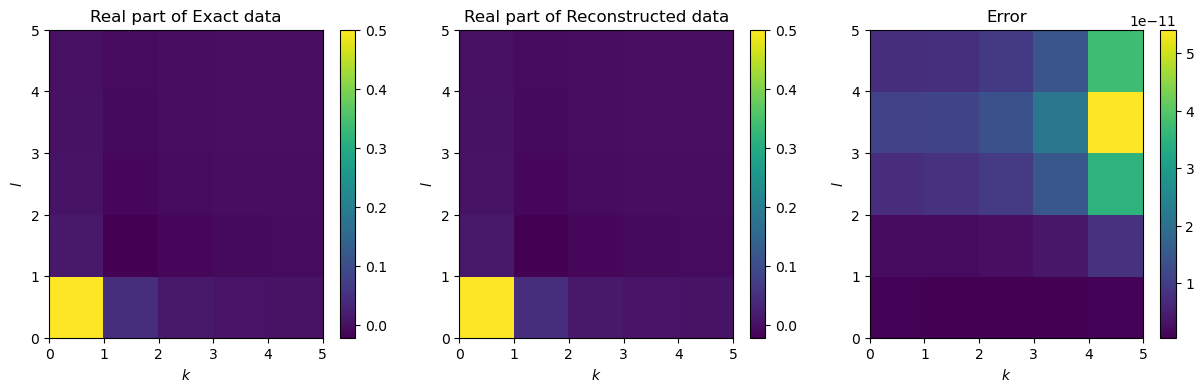

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

klgrid = QG.InherentDiscreteGrid{2}(R, (0, 0); unfoldingscheme=:interleaved)

sparse1dgrid = collect(0:4)

reconstdata = [
    _evaluate(hfmps2_reverse, sites_kl, QG.origcoord_to_quantics(klgrid, (k, l)))
    for k in sparse1dgrid, l in sparse1dgrid]

hfkl(k::Integer, l::Integer) = _expk(k, ϵ) * _expk(l, ϵprime)

exactdata = [hfkl(k, l) for k in sparse1dgrid, l in sparse1dgrid]

c = ax1.pcolor(real.(exactdata))
fig.colorbar(c, ax=ax1)
ax1.set_xlabel(L"k")
ax1.set_ylabel(L"l")
ax1.set_title("Real part of Exact data")

c = ax2.pcolor(real.(reconstdata))
fig.colorbar(c, ax=ax2)
ax2.set_xlabel(L"k")
ax2.set_ylabel(L"l")
ax2.set_title("Real part of Reconstructed data")

c = ax3.pcolor(abs.(exactdata .- reconstdata))
fig.colorbar(c, ax=ax3)
ax3.set_xlabel(L"k")
ax3.set_ylabel(L"l")
ax3.set_title("Error")

_display(fig)